Straighten an image based on a mask using a mesh of points

This is the mask and image we will use:

In [1]:
%load_ext autoreload
%autoreload 2

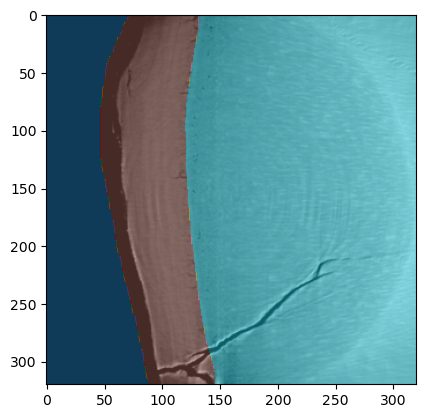

In [2]:
""" Display the image and mask """
import pickle
import matplotlib.pyplot as plt

with open("cementum_data.pickle", "rb") as data:
    _, _, test_images, test_masks = pickle.load(data)


# Just pick the first image for now
image, mask = test_images[0], test_masks[0]
plt.imshow(image, cmap="grey")
plt.imshow(mask, cmap="tab10", alpha=0.5)

We'll first identify the two edges and fit polynomials to them:

In [3]:
"""
Convert the masks from integers to uint8

"""
import numpy as np

assert (np.unique(mask) == [0, 1, 2]).all()

normalised_mask = (
    (mask - np.min(mask)) * 255.0 / (np.max(mask) - np.min(mask))
).astype(np.uint8)

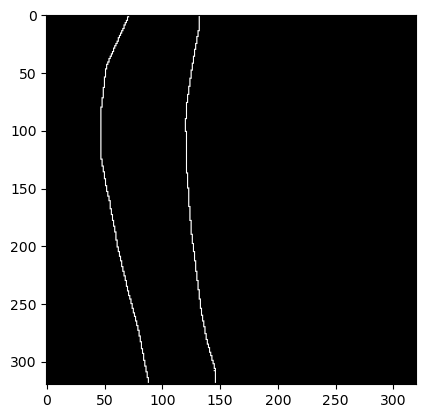

In [4]:
"""
Show the mask edge identification

"""
from cementum import straighten

# Find edges
edges = straighten.find_edges(normalised_mask)

# Choose a value above which to consider an edge
edge_threshold = 10
edges[edges >= edge_threshold] = 1.0
plt.imshow(edges, cmap="grey")

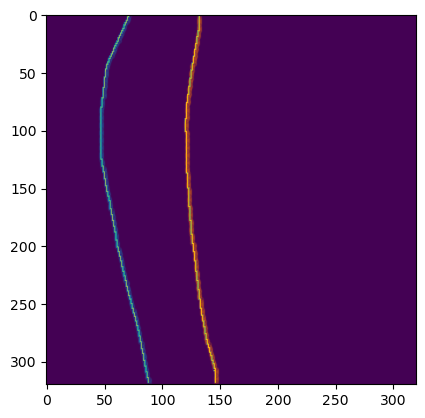

In [5]:
"""
Show how we identify the first and second edge

"""
first_edge, second_edge = straighten._identify_edges(edges)

plt.imshow(edges)
plot_kw = {"marker": ".", "alpha": 0.1}
plt.plot(first_edge[:, 0], first_edge[:, 1], **plot_kw)
plt.plot(second_edge[:, 0], second_edge[:, 1], **plot_kw)

Text(0.5, 1.0, 'Polynomial fits to edges')

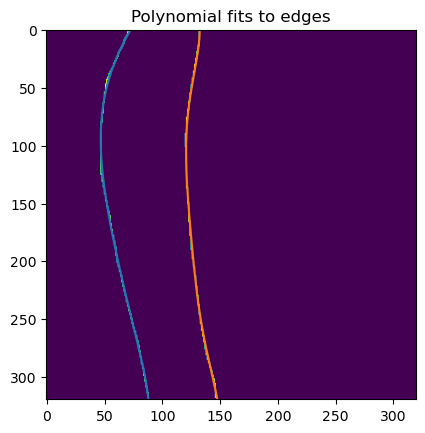

In [6]:
"""
Fit a polynomial to the smoothed edges

"""
plt.imshow(edges)

poly_degree = 6

first_poly = straighten._fit_polynomial(first_edge, poly_degree)
second_poly = straighten._fit_polynomial(second_edge, poly_degree)

y_vals = np.arange(0, image.shape[0])

plt.plot(first_poly(y_vals), y_vals)
plt.plot(second_poly(y_vals), y_vals)

plt.title("Polynomial fits to edges")

Now we need to find the area between the two curves, and a rectangle of equivalent area. We'll set this rectangle's height to the average of the two curve lengths:

21230.5
62.75049388321768


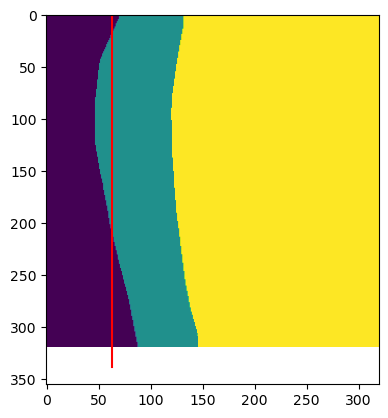

In [35]:
"""
Find the rectangle that we will map our region onto

"""
from shapely import Polygon


def length(curve: np.ndarray) -> float:
    return np.sum(np.sqrt(np.diff(curve[:, 0]) ** 2 + np.diff(curve[:, 1]) ** 2))


def area(curve1: np.ndarray, curve2: np.ndarray) -> float:
    # Create a shapely polygon
    # Reverse the second curve so that the polygon is closed and the points describe
    # a path around it in the right sense
    return Polygon(np.vstack([curve1, curve2[::-1]])).area


rectangle_height = (length(first_edge) + length(second_edge)) / 2
total_area = area(first_edge, second_edge)
print(total_area)

rectangle_width = total_area / rectangle_height
print(rectangle_width)

plt.imshow(mask)
plt.plot([rectangle_width] * 2, [0, rectangle_height], color="red")

First we'll use an evenly spaced Cartesian grid as our mesh...

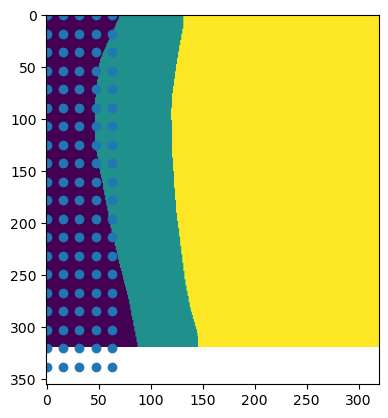

In [46]:
"""
Create grids of points to map to/from

"""
n_x, n_y = 5, 20

rect_y = np.linspace(0, rectangle_height, n_y, endpoint=True)
rect_x = np.linspace(0, rectangle_width, n_x, endpoint=True)

rect_pts = []
for x in rect_x:
    for y in rect_y:
        rect_pts.append([y, x])
rect_pts = np.array(rect_pts)

plt.imshow(mask)
plt.plot(rect_pts[:, 1], rect_pts[:, 0], "o")

# Find y values for the midpoint of the two lines
# Find the distance between the curves at each y value
# Find x values for the curves